
GPT-4o Classification Results:
Filename: Fetal Brain Abnormalities Ultrasound.v1i.multiclass/test/Copy-of-mild-ventriculomegaly-18c_aug_2_png_jpg.rf.1a7978b80bec239d05c1870f509b7aaa.jpg
True Label: mild ventriculomegaly
Predicted Label: mild ventriculomegaly
Analysis: The ultrasound image displays a fetal brain in a coronal section. Notable visual features include the presence of a pronounced fluid-filled space within the brain. The lateral ventricles appear enlarged, yet their overall shape is maintained without asymmetry.

The enlargement of the ventricles suggests ventriculomegaly. The degree of dilation does not appear extremely pronounced, but it is significant enough to fall under mild to moderate classification. The surrounding brain structures do not show signs of malformation or crowding, suggesting that more severe pathologies like hydrocephalus or severe ventriculomegaly are unlikely.

Based on the visual analysis, the features are consistent with mild ventriculomegaly, as 

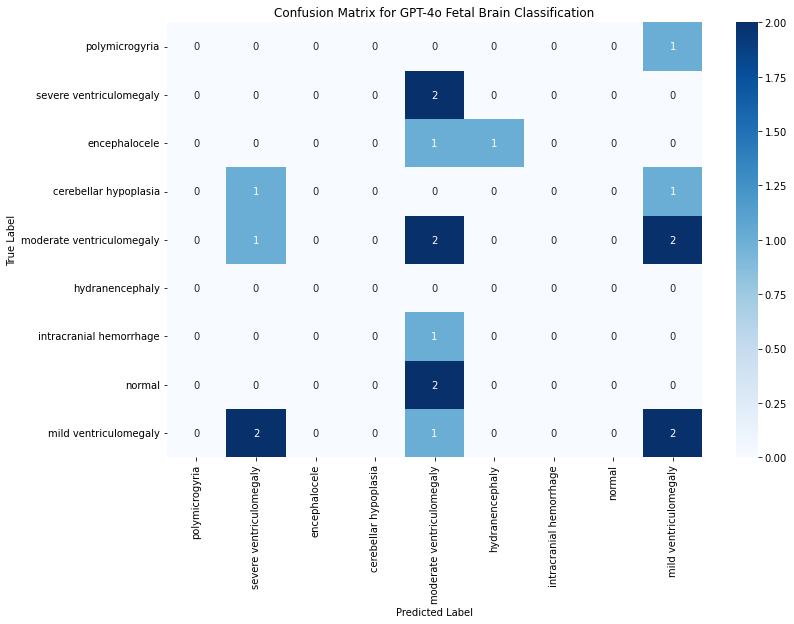

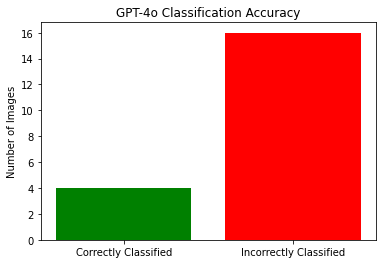

In [17]:
import openai
import base64
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# OpenAI API Key
openai.api_key = "-""
# List of valid classification labels
VALID_CONDITIONS = [
    "arnold chiari malformation", "arachnoid cyst", "cerebellar hypoplasia", "colpocephaly",
    "encephalocele", "holoprosencephaly", "hydranencephaly", "intracranial hemorrhage",
    "intracranial tumor", "mega cisterna magna", "mild ventriculomegaly", "moderate ventriculomegaly",
    "normal", "polymicrogyria", "severe ventriculomegaly", "vein of galen malformation"
]

def encode_image(image_path):
    """ Convert an image to base64 encoding for OpenAI Vision API. """
    if not os.path.exists(image_path):
        print(f"Warning: Missing image {image_path}")
        return None
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def analyze_ultrasound(image_path):
    """ Analyzes a fetal brain ultrasound image with GPT-4o. """
    image_base64 = encode_image(image_path)
    if image_base64 is None:
        return None

    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": (
                    "You are an AI specializing in pattern recognition in fetal brain ultrasound images. "
                    "Analyze the given image and describe any notable visual features, such as shape, structure, symmetry, and fluid distribution. "
                    "Then, classify the image into exactly one of the following conditions: " + ", ".join(VALID_CONDITIONS) + ". "
                    "**Ensure that you provide a detailed analysis before stating the final classification.** "
                    "At the very end, explicitly state the classification in this format:\n\n"
                    "**Final Classification: [exact condition from the list above]**\n\n"
                )},
                {"role": "user", "content": [
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
                ]}
            ],
            max_tokens=500
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error calling GPT-4o API: {e}")
        return None

def extract_final_classification(analysis_report):
    """ Extracts the final classification from GPT-4o's response and standardizes it. """
    if not analysis_report:
        return "unknown"

    lines = analysis_report.strip().split("\n")
    for line in reversed(lines):  
        line = line.strip().lower()
        if "final classification:" in line:
            pred_label = line.split("final classification:")[-1].strip()
            pred_label = re.sub(r"[^\w\s]", "", pred_label)  # Remove punctuation
            pred_label = pred_label.lower()

            # Ensure only valid labels are accepted
            if pred_label in VALID_CONDITIONS:
                return pred_label
            else:
                print(f"Warning: Invalid classification '{pred_label}' from GPT-4o.")
    return "unknown"

def get_ground_truth(row):
    """ Extract the ground truth label from the dataset, handling multiple labels. """
    labels = [col for col in row.index[1:] if row[col] == 1]
    return labels[0] if len(labels) == 1 else "multiple" if labels else "unknown"

def evaluate_gpt4o(dataset_path):
    """ Evaluates GPT-4o performance on a dataset of images with ground truth labels. """
    results = []
    
    # Load dataset (image filenames and one-hot encoded labels)
    dataset = pd.read_csv(dataset_path, encoding="utf-8", on_bad_lines='skip')
    dataset['ground_truth'] = dataset.apply(get_ground_truth, axis=1)
    
    # Process first 20 images for testing
    for _, row in dataset.head(20).iterrows():
        image_path = os.path.join("Fetal Brain Abnormalities Ultrasound.v1i.multiclass", "test", row['filename'])
        true_label = row['ground_truth']
        if os.path.exists(image_path):
            analysis_report = analyze_ultrasound(image_path)
            pred_label = extract_final_classification(analysis_report)
            results.append({"image": image_path, "true_label": true_label, "predicted_label": pred_label, "analysis": analysis_report})
        else:
            print(f"Skipping missing image: {image_path}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    results_df.to_csv("gpt4o_ultrasound_results.csv", index=False)
    
    # Print results
    print("\nGPT-4o Classification Results:")
    for _, row in results_df.iterrows():
        print(f"Filename: {row['image']}")
        print(f"True Label: {row['true_label']}")
        print(f"Predicted Label: {row['predicted_label']}")
        print(f"Analysis: {row['analysis']}")
        print("-" * 80)
    
    # Convert labels to lowercase for consistency
    y_true = results_df['true_label'].str.lower()
    y_pred = results_df['predicted_label'].str.lower()

    # Define all conditions (including "unknown" for confusion matrix)
    all_conditions = list(set(y_true.unique()) | set(y_pred.unique()))
    all_conditions = [label for label in all_conditions if label in VALID_CONDITIONS or label == "unknown"]

    # Compute overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # Generate classification report
    valid_labels = VALID_CONDITIONS  # Include all possible conditions, not just ones seen in y_true/y_pred
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=valid_labels, zero_division=1))

    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred, labels=all_conditions)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=all_conditions, yticklabels=all_conditions)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for GPT-4o Fetal Brain Classification")
    plt.show()

    # Bar Graph: Correct vs Incorrect Classifications
    correct_classifications = int((y_true == y_pred).sum())  # Ensure it's an integer
    incorrect_classifications = int(len(y_true) - correct_classifications)  # Convert to int
    plt.figure(figsize=(6, 4))
    plt.bar(["Correctly Classified", "Incorrectly Classified"], [correct_classifications, incorrect_classifications], color=['green', 'red'])
    plt.ylabel('Number of Images')
    plt.title('GPT-4o Classification Accuracy')
    plt.xticks(rotation=0)
    plt.show()


# Run evaluation
dataset_path = os.path.join("Fetal Brain Abnormalities Ultrasound.v1i.multiclass", "test", "_classes - _classes.csv")
if os.path.exists(dataset_path):
    evaluate_gpt4o(dataset_path)
else:
    print("Dataset file not found! Ensure you provide a valid CSV.")
